# 一、环境准备

在命令行中执行下面的命令，安装 Python 依赖库

辅助文档：https://yju67c1ngj.feishu.cn/docx/SqyedEAPCoUPc9xvyvRctP3PnAd?from=from_copylink

下文提到的 cookie 参数需要替换为自己的

In [ ]:
!pip install openai requests matplotlib numpy pandas fake-useragent jieba wordcloud

上传字体文件，后面绘制图形需要，避免中文乱码

In [ ]:
!wget -O /usr/share/fonts/truetype/liberation/simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf"

import matplotlib as mpl
zhfont = mpl.font_manager.FontProperties(fname='/usr/share/fonts/truetype/liberation/simhei.ttf')

--2023-11-26 12:18:38--  https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf
Resolving www.wfonts.com (www.wfonts.com)... 172.67.129.58, 104.21.1.127, 2606:4700:3037::6815:17f, ...
Connecting to www.wfonts.com (www.wfonts.com)|172.67.129.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050870 (9.6M) [application/octetstream]
Saving to: ‘/usr/share/fonts/truetype/liberation/simhei.ttf’

/usr/share/fonts/tr 100%[===================>]   9.58M  5.35MB/s    in 1.8s    

2023-11-26 12:18:41 (5.35 MB/s) - ‘/usr/share/fonts/truetype/liberation/simhei.ttf’ saved [10050870/10050870]



# 二、模拟 URL 获取 和 AI 辅助解析参数


这里我们使用知识星球网页版进行爬取，首先用登陆知识星球，进入星球的精华文章 tab 页，查看请求的url 和 headers，浏览器打开F12查看
:
Reauest URL: 请求地址

Request Headers：请求参数

1、AI 辅助将 headers 参数转化为 json

https://sharegpt.com/c/meVQO7Z



2、去掉 Json 中的无效header参数

In [ ]:
{
    ":authority": "api.zsxq.com",
    ":method": "GET",
    ":path": "/v2/groups/15552545485212/topics?scope=digests&count=20",
    ":scheme": "https"
}

3、得到最终的请求参数

In [ ]:
{
  "Accept": "application/json, text/plain, */*",
  "Accept-Encoding": "gzip, deflate, br",
  "Accept-Language": "zh-CN,zh;q=0.9",
  "Cookie": "xxxx",
  "Dnt": "1",
  "Origin": "https://wx.zsxq.com",
  "Referer": "https://wx.zsxq.com/",
  "Sec-Ch-Ua": "\"Google Chrome\";v=\"119\", \"Chromium\";v=\"119\", \"Not?A_Brand\";v=\"24\"",
  "Sec-Ch-Ua-Mobile": "?0",
  "Sec-Ch-Ua-Platform": "\"macOS\"",
  "Sec-Fetch-Dest": "empty",
  "Sec-Fetch-Mode": "cors",
  "Sec-Fetch-Site": "same-site",
  "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36",
  "X-Request-Id": "e72520c8c-f2d6-11af-e04f-70e159bca0d",
  "X-Signature": "0415cf7b5f5fa58a4600dcaad89eb9d0d6bc7a65",
  "X-Timestamp": "1700909364",
  "X-Version": "2.47.0"
}


# 三、爬虫获取破局星球精华文章

In [ ]:
from urllib.parse import quote
import time
import random
import requests
from fake_useragent import UserAgent
import datetime
import json

class ZsxqDataFetcher:
    def __init__(self, base_url):
        self.base_url = base_url

    def _generate_headers(self):
        ua = UserAgent()
        user_agent = ua.random
        return {
          "Accept": "application/json, text/plain, */*",
          "Accept-Encoding": "gzip, deflate, br",
          "Accept-Language": "zh-CN,zh;q=0.9,en;q=0.8,en-GB;q=0.7,en-US;q=0.6",
          "Cookie": "xxx",
          "Origin": "https://wx.zsxq.com",
          "Referer": "https://wx.zsxq.com/",
          "Sec-Ch-Ua": "\"Microsoft Edge\";v=\"119\", \"Chromium\";v=\"119\", \"Not?A_Brand\";v=\"24\"",
          "Sec-Ch-Ua-Mobile": "?0",
          "Sec-Ch-Ua-Platform": "\"Windows\"",
          "Sec-Fetch-Dest": "empty",
          "Sec-Fetch-Mode": "cors",
          "Sec-Fetch-Site": "same-site",
          "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36 Edg/119.0.0.0",
          "X-Request-Id": "45a6d3d07-dc22-9528-a85d-8227b4e61cf",
          "X-Signature": "9c7f1b86ca20b770d66763bb53e38be782444e70",
          "X-Timestamp": "1700996495",
          "X-Version": "2.47.0"
      }



    def _get_data(self, url):
        headers = self._generate_headers()
        max_retries = 5
        for _ in range(max_retries):
            rsp = requests.get(url, headers=headers)
            topics = rsp.json().get('resp_data').get('topics')

            #print("获取每页数据", rsp.status_code, len(topics) if topics is not None else 0)
            if rsp.status_code == 200 and topics is not None:
                return topics
            time.sleep(1)

        return []

    def _format_next_page_url(self, last_topic_create_time):
        end_time = last_topic_create_time[:20]+str(int(last_topic_create_time[20:23])-1).zfill(3)+last_topic_create_time[23:]
        if last_topic_create_time[20:23] == '000':
            temp_time = datetime.datetime.strptime(last_topic_create_time, "%Y-%m-%dT%H:%M:%S.%f+0800")
            temp_time += datetime.timedelta(seconds=-1)
            end_time = temp_time.strftime("%Y-%m-%dT%H:%M:%S") + '.999+0800'

        end_time = quote(end_time)
        return self.base_url + '&end_time=' + end_time

    def fetch_all_topics(self):
        topics = self._get_data(self.base_url)
        while True:
            last_topic = topics[-1] if topics else None
            if not last_topic:
                break

            next_url = self._format_next_page_url(last_topic.get('create_time'))
            time.sleep(random.uniform(5, 10))
            next_page = self._get_data(next_url)
            if not next_page:
                break

            topics += next_page
            print("获取数据", len(topics))

        return topics

# 使用示例
base_url = "https://api.zsxq.com/v2/groups/15552545485212/topics?scope=digests&count=20"
fetcher = ZsxqDataFetcher(base_url)
all_topics = fetcher.fetch_all_topics()
print(len(all_topics))

# 同步到json文件，方便查看内容
json_object = json.dumps(all_topics, indent=4, ensure_ascii=False)
with open("topics.json", "w") as outfile:
    outfile.write(json_object)
topics = all_topics

获取数据 40
获取数据 60
获取数据 80
获取数据 100
获取数据 120
获取数据 140
获取数据 160
获取数据 180
获取数据 200
获取数据 220
获取数据 240
获取数据 260
获取数据 280
获取数据 300
获取数据 320
获取数据 340
获取数据 357
357


In [ ]:
# 读取JSON文件
with open('topics.json', 'r') as file:
    topics = json.load(file)

# 四、数据预处理

In [ ]:
import pandas as pd
from  datetime import datetime
tmpArr = []
for item in topics:
    # 过滤无效的文章
    if 'talk' not in item:
        print("No talk", item)
        continue

    # 文章内容分两种形式：纯文本 + 链接
    if 'article' not in item['talk']:
        title = item["talk"]["text"]
        html_content = item["talk"]["text"]
        acticle_url = ""
    else:
        title = item["talk"]["article"]["title"]
        #html_content = requests.get(item["talk"]["article"]["inline_article_url"]).content
        html_content = ""
        acticle_url = item["talk"]["article"]["inline_article_url"]
        tmpArr.append(
          {
              "title": title,
              "owner": item["talk"]["owner"]["name"],
              "location": item["talk"]["owner"]["location"],
              "create_time": item["create_time"],
              "readers_count": item["readers_count"],
              "likes_count": item["likes_count"],
              "article_url": acticle_url,
              "acticle_content": html_content,
              "hour": datetime.strptime(item["create_time"], "%Y-%m-%dT%H:%M:%S.%f%z").hour
          }
        )
df = pd.DataFrame(tmpArr)
df.to_csv("topics.csv")
df.head()
df = df[df['owner'] != 'findyi']
print(df.shape)


No talk {'topic_id': 211215112828241, 'group': {'group_id': 15552545485212, 'name': 'AI破局俱乐部', 'type': 'pay', 'background_url': 'https://images.zsxq.com/FslG2Iw17zo1nk4F_XhCrWvxbcR7?e=1704038399&token=kIxbL07-8jAj8w1n4s9zv64FuZZNEATmlU_Vm6zD:tsqPd2LDgT-ZwGcDtvh4t4SVTmk='}, 'type': 'task', 'task': {'owner': {'user_id': 51544811224184, 'name': 'findyi', 'avatar_url': 'https://images.zsxq.com/FjoYYKf24IAnA-qdduT3wHfrs9KX?e=1704038399&token=kIxbL07-8jAj8w1n4s9zv64FuZZNEATmlU_Vm6zD:bk0m5aITgrVp250Z0TI5A5d7XtY=', 'description': '前360技术总监、担任过独角兽公司CTO、腾讯TVP', 'location': '北京'}, 'text': '大家晚上好呀。今天是一年一度的感恩节啦。\n\n时间如白驹过隙，匆匆忙忙又到今日。我今天思考的时候，不由得回想起，AI破局这一路走来的故事。而我，有太多想要感谢的贵人。\n\n今天晚上你一定会抽时间和自己在意的人通话吧。\n\n那么在你看到这个活动的当下，AI破局的圈子里，你想起了与谁的故事？又想向谁说一声感谢呢？\n\n和我分享一下吧。\n\n点赞多的故事，我会送你礼物🎁。\n\n活动明天晚上8点截止。', 'images': [{'image_id': 181544221551182, 'type': 'jpg', 'thumbnail': {'url': 'https://images.zsxq.com/FrWPJcTtjDWn3dtoLoxZqtGakgbJ?imageMogr2/auto-orient/thumbnail/750x/format/jpg/blur/1x0/quality/75&e=17040

# 五、文章作者拆解

In [ ]:
# 统计每位作者的文章数
author_article_counts = df['owner'].value_counts().reset_index()
author_article_counts.columns = ['author', 'article_count']
# 展示前 20个 作者
author_article_counts.head(20)

,author,article_count
0,小潘,21
1,小七姐,9
2,皮特,9
3,闫小林,8
4,段老湿,7
5,王强@ZelinAI,4
6,叫我峰兄,4
7,卡尔,4
8,杨其顶,3
9,秋仁,3


# 六、作者所在城市分析

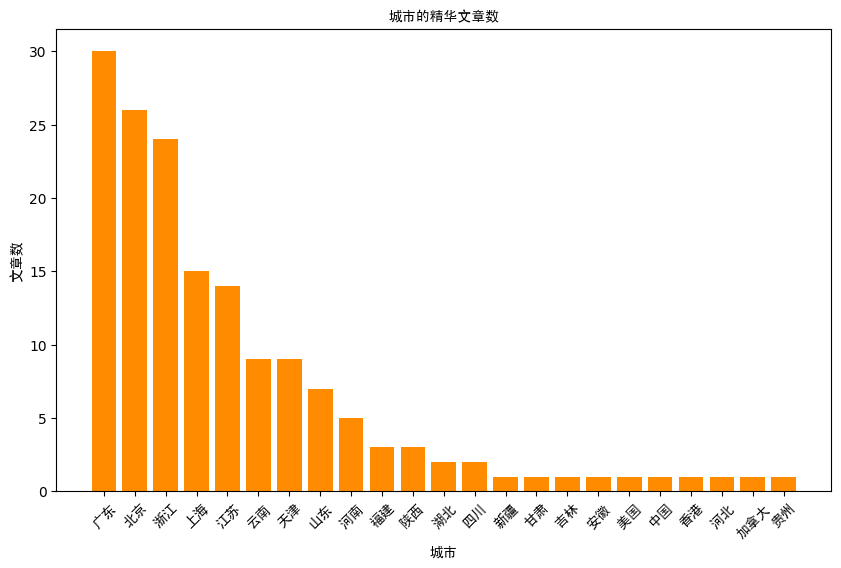

In [ ]:
import matplotlib.pyplot as plt

# 覆盖了多少个城市
# 统计每位作者的文章数
metrics = df['location'].value_counts().reset_index()
metrics.columns = ['X', 'Y']

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(metrics['X'], metrics['Y'], color='darkorange')
plt.xlabel('城市', fontproperties=zhfont)
plt.ylabel('文章数', fontproperties=zhfont)
plt.title('城市的精华文章数', fontproperties=zhfont)
plt.xticks(rotation=45, fontproperties=zhfont)  # 旋转 X 轴标签，使其更易读
plt.show()

# 七、文章发表时间分析

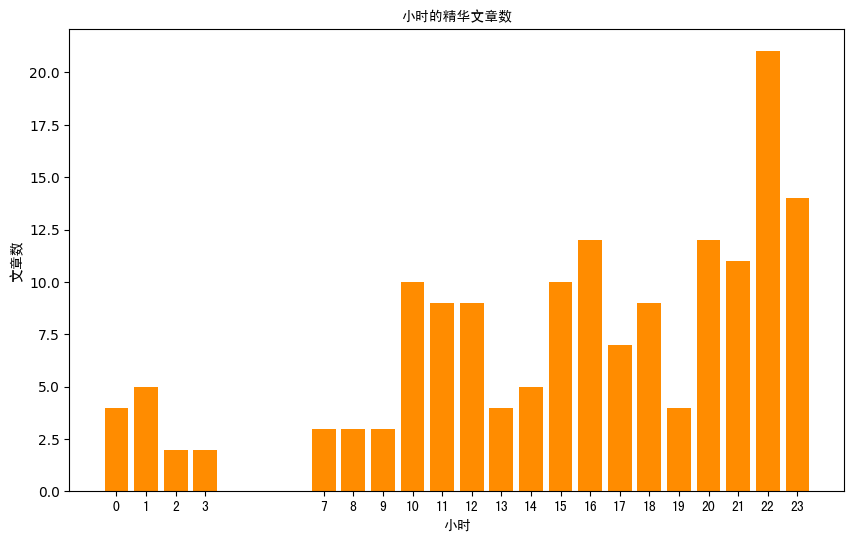

In [ ]:
import matplotlib.pyplot as plt

metrics = df['hour'].value_counts().reset_index()
metrics.columns = ['X', 'Y']

# 绘制柱状图
plt.figure(figsize=(10, 6))
metrics
plt.bar(metrics['X'], metrics['Y'], color='darkorange')
plt.xlabel('小时', fontproperties=zhfont)
plt.ylabel('文章数', fontproperties=zhfont)
plt.title('小时的精华文章数', fontproperties=zhfont)
plt.xticks(metrics['X'], fontproperties=zhfont) # 设置 x 轴刻度和标签
# plt.xticks(rotation=45)  # 旋转 X 轴标签，使其更易读
plt.show()

# 八、阅读数分析

## 一）查看某个作者的文章

In [ ]:
df2 = df[df['article_url'] != '']
df2 = df[df['owner'] == '木川']
print(df2.shape)

df_sorted = df2.sort_values(by="readers_count", ascending=False)
for index, row in df_sorted.iterrows():
    print(f"title: {row['title'][:30]}, owner: {row['owner']}, article_url: {row['article_url']}, {row['readers_count']}, {row['likes_count']}")

(3, 9)
title: CodeGeex 编程大模型应用复盘, owner: 木川, article_url: https://articles.zsxq.com/inline_form/id_arb464kfrkjn.html, 5845, 89
title: 我用 AI + 编程拆解了破局 300+ 精华文章，我惊呆了, owner: 木川, article_url: https://articles.zsxq.com/inline_form/id_wu8tqxikt3wo.html, 4893, 152
title: 加入破局 180 天，成功立起 IP, owner: 木川, article_url: https://articles.zsxq.com/inline_form/id_357cf87dxfeq.html, 3101, 64


## 二）计算不同分位数下的文章阅读数，绘制箱线图

50 分位数：6259.0
75 分位数：10489.0
90 分位数：12936.2
95 分位数：13984.0
100 分位数：20783.0


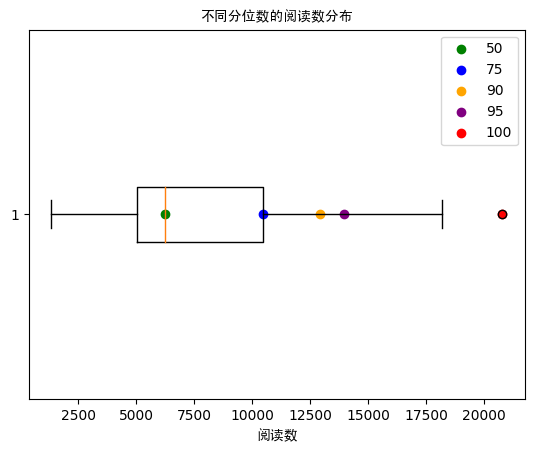

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

readership_data = df["readers_count"]

# 创建箱线图
# 计算不同分位数
percentiles = [50, 75, 90, 95, 100]
percentile_values = np.percentile(readership_data, percentiles)

# 打印分位数的值
for p, value in zip(percentiles, percentile_values):
    print(f"{p} 分位数：{value}")

# 绘制箱线图
plt.boxplot(readership_data, vert=False)

# 添加不同颜色的分位数标识
colors = ['green', 'blue', 'orange', 'purple', 'red']
for p, value, color in zip(percentiles, percentile_values, colors):
    plt.scatter(value, 1, color=color, marker='o', label=f"{p}")

# 设置标签和标题
plt.xlabel("阅读数", fontproperties=zhfont)
plt.title("不同分位数的阅读数分布", fontproperties=zhfont)

# 添加图例
plt.legend()

# 显示图表
plt.show()

## 三）统计不同阅读数区间的文章数，绘制直方图

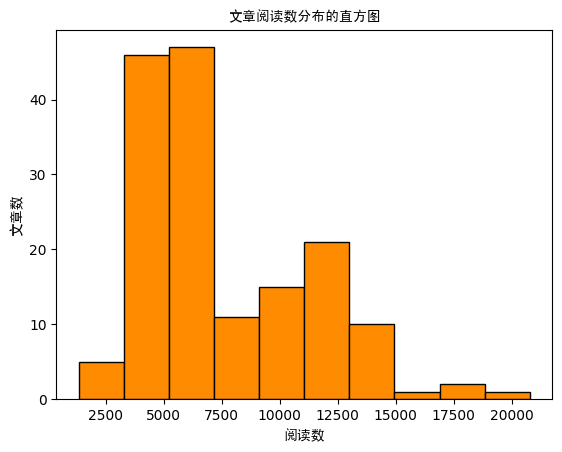

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

readership_data = df["readers_count"]
plt.hist(readership_data, bins=10, color='darkorange', edgecolor='k')

plt.xlabel("阅读数", fontproperties=zhfont)
plt.ylabel("文章数", fontproperties=zhfont)
plt.title("文章阅读数分布的直方图", fontproperties=zhfont)
plt.show()

## 四）统计阅读数 top 10 的文章

In [ ]:
df_sorted = df.sort_values(by="readers_count", ascending=False)
top_10 = df_sorted.head(10)
top_10[['title', 'owner', 'readers_count', 'article_url']]

,title,owner,readers_count,article_url
123,0代码基础小白使用ChatGPT做出一款谷歌全屏截图插件的全过程,阿强,20783,https://articles.zsxq.com/inline_form/id_grll0...
121,如何利用 ChatGPT 辅助写作,闫小林,18195,https://articles.zsxq.com/inline_form/id_9xwa8...
158,第三课-常用的AI应用（100款）,王强@ZelinAI,17508,https://articles.zsxq.com/inline_form/id_g7vpi...
122,如何用ChatGPT， 每天自动批量产出100+条爆款短视频,🍀刘驴💥,15976,https://articles.zsxq.com/inline_form/id_e74ag...
144,阿里通义千问试玩~,鱼皮,14805,https://articles.zsxq.com/inline_form/id_1orqj...
133,使用AI，做抖音漫画短视频，4个人2天的工作量，1人仅需5小时即可完成！,蛋解创业蛋蛋,14583,https://articles.zsxq.com/inline_form/id_4kdt0...
147,分享一下我是如何用AI助手来提升工作效率的,王强@ZelinAI,14239,https://articles.zsxq.com/inline_form/id_zwopk...
152,前端大佬强推！！！用ChatGPT提升代码质量,小潘,14029,https://articles.zsxq.com/inline_form/id_b1556...
124,我做的AI律所：不仅律师自发传播，竟然还吸引了大佬王小川？,台风-2号,13979,https://articles.zsxq.com/inline_form/id_oug13...
155,新手入门必看课程,小潘,13946,https://articles.zsxq.com/inline_form/id_zr061...


# 九、点赞数分析

## 二）计算不同分位数下的文章点赞数，绘制箱线图

50 分位数：137.0
75 分位数：202.5
90 分位数：280.40000000000003
95 分位数：314.2
100 分位数：524.0


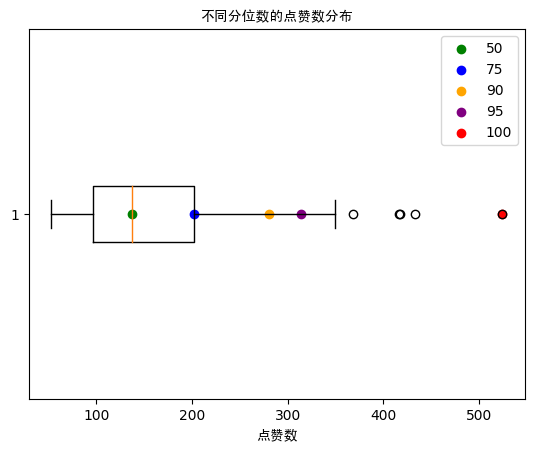

In [ ]:

readership_data = df["likes_count"]
# 创建箱线图
# 计算不同分位数
percentiles = [50, 75, 90, 95, 100]
percentile_values = np.percentile(readership_data, percentiles)

# 打印分位数的值
for p, value in zip(percentiles, percentile_values):
    print(f"{p} 分位数：{value}")

# 绘制箱线图
plt.boxplot(readership_data, vert=False)

# 添加不同颜色的分位数标识
colors = ['green', 'blue', 'orange', 'purple', 'red']
for p, value, color in zip(percentiles, percentile_values, colors):
    plt.scatter(value, 1, color=color, marker='o', label=f"{p}")

# 设置标签和标题
plt.xlabel("点赞数", fontproperties=zhfont)
plt.title("不同分位数的点赞数分布", fontproperties=zhfont)

# 添加图例
plt.legend()

# 显示图表
plt.show()

## 三）统计不同点赞数区间的文章数，绘制直方图

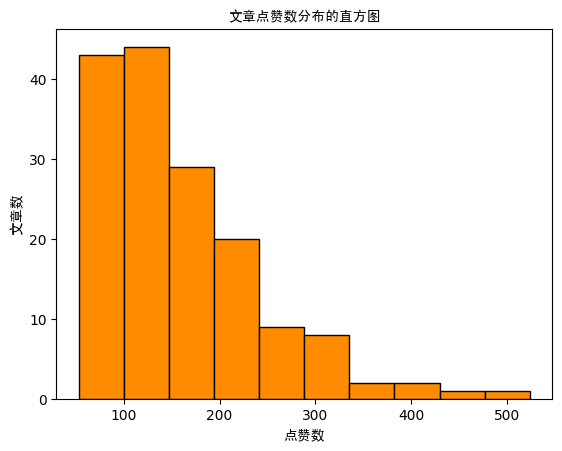

In [ ]:
import matplotlib.pyplot as plt

readership_data = df["likes_count"]
plt.hist(readership_data, bins=10, color='darkorange', edgecolor='k')

plt.xlabel("点赞数", fontproperties=zhfont)
plt.ylabel("文章数", fontproperties=zhfont)
plt.title("文章点赞数分布的直方图", fontproperties=zhfont)
plt.show()

## 四）统计点赞数 top 10 的文章

In [ ]:
df_sorted = df.sort_values(by="likes_count", ascending=False)
top_10 = df_sorted.head(10)
top_10[['title', 'owner', 'likes_count', 'article_url']]

,title,owner,likes_count,article_url
121,如何利用 ChatGPT 辅助写作,闫小林,524,https://articles.zsxq.com/inline_form/id_9xwa8...
123,0代码基础小白使用ChatGPT做出一款谷歌全屏截图插件的全过程,阿强,433,https://articles.zsxq.com/inline_form/id_grll0...
122,如何用ChatGPT， 每天自动批量产出100+条爆款短视频,🍀刘驴💥,417,https://articles.zsxq.com/inline_form/id_e74ag...
124,我做的AI律所：不仅律师自发传播，竟然还吸引了大佬王小川？,台风-2号,416,https://articles.zsxq.com/inline_form/id_oug13...
134,4个公式8个案例学会与chatGPT对话,星球助理-matao,368,https://articles.zsxq.com/inline_form/id_jlxv2...
118,给送每一个AI创业者的避坑指南,叫我峰兄,349,https://articles.zsxq.com/inline_form/id_02dga...
130,Midjourney入门必看课程,小潘,317,https://articles.zsxq.com/inline_form/id_sh42v...
111,分享一个ChatGPT提示词技巧,阿铭,316,https://articles.zsxq.com/inline_form/id_f6itk...
86,一只￥4000的prompt订单：有需求就有价值,小七姐,314,https://articles.zsxq.com/inline_form/id_92w3e...
103,零基础自建Stable Difussion绘图(1),小潘,312,https://articles.zsxq.com/inline_form/id_hctce...


# 十、关键词拆解

## 一）Python 词云分析拆解

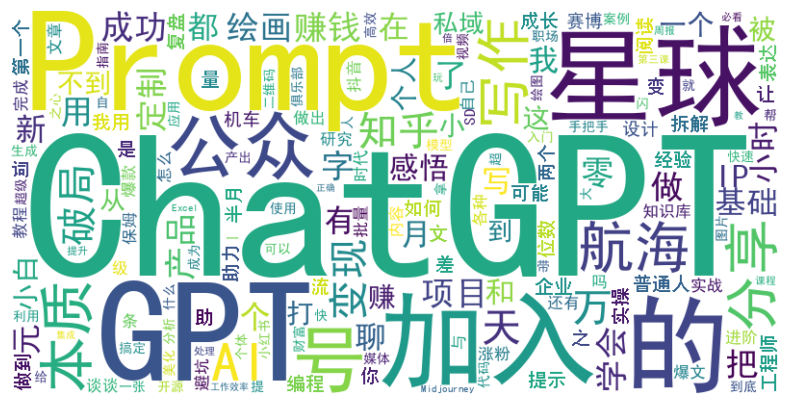

In [ ]:
import jieba
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 准备文本数据
words = []
for index, row in df.iterrows():
    title = row.title[:24]
    keywords = jieba.cut(title)
    # print(title, " ".join(keywords))
    for item in keywords:
        words.append(item)
# 使用Counter统计元素出现的次数
element_counts = Counter(words)

# 提取出现次数为2次或更多的元素
result = [element for element, count in element_counts.items() if count >= 2]
text = " ".join(result)

# todo 修改中文字体文件路径，创建词云对象并生成词云图像
font_path = "/usr/share/fonts/truetype/liberation/simhei.ttf"
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate(text)

# 显示词云图像
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 隐藏坐标轴
plt.show()

## 二）ChatGPT 拆解



```
SYSTERM
请从我给你的一段标题中提取关键词输出
USER
CodeGeex 编程大模型应用复盘
```





```
SYSTERM
请从我给你的一段标题中提取关键词输出
USER
为啥我打算，重新做一家一人企业？
```



## 三）Python 调用 OpenAI 拆解

api_key 参数需要自己设置

In [ ]:
from openai import OpenAI

client = OpenAI(
    api_key="",
)
completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "请从我给你的一段标题中提取关键词输出"},
    {"role": "user", "content": "CodeGeex 编程大模型应用复盘"},
  ]
)

print(completion.choices[0].message.content)

CodeGeex, 编程, 大模型, 应用, 复盘


# 十一、内容拆解

## 一）ChatGPT 拆解



```
SYSTERM
请总结这篇文章的内容
USER
<内容>
```



## 二）Python 调用 OpenAI 拆解

api_key 参数需要自己设置

In [ ]:
from openai import OpenAI
client = OpenAI(
    api_key="",
)
completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "请总结这篇文章的内容"},
    {"role": "user", "content": "CodeGeeX，由清华大学知识工程实验室开发的智能编程助手，支持多种编程语言如Python、Java、C++等，并兼容多种IDE，例如VSCode和JetBrains系列。它基于一个130亿参数的预训练模型，具有代码生成、注释添加、代码翻译和智能问答等功能。CodeGeeX在代码生成和翻译任务上表现优异，超越其他开源模型。它的插件现已免费上架于VSCode市场，提供自定义代码生成风格。此外，CodeGeeX支持昇腾和英伟达平台，其代码和模型权重已开源。调研显示83.4%的用户认为CodeGeeX有助于提高编程效率"},
  ]
)
print(completion.choices[0].message.content)

CodeGeeX是一款由清华大学知识工程实验室开发的智能编程助手。它支持多种编程语言，如Python、Java、C++等，并兼容多种IDE，如VSCode和JetBrains系列。该助手基于一个拥有130亿参数的预训练模型，具备代码生成、注释添加、代码翻译和智能问答等功能。

在代码生成和翻译任务方面，CodeGeeX表现出色，超越其他开源模型。它还提供了自定义代码生成风格的功能，可以根据用户的需求进行个性化设置。该助手的插件已经免费上架于VSCode市场。

CodeGeeX还支持昇腾和英伟达平台，用户可以根据自己的硬件平台选择合适的版本。它的代码和模型权重已经开源，用户可以自由使用和修改。

根据调研显示，83.4%的用户认为CodeGeeX有助于提高编程效率。这款智能编程助手为开发者提供了强大的功能和灵活的配置选项，有助于简化编程过程，并提高工作效率。
